In [39]:
import sys
sys.path.append('/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods')
from settings import *
import helpers
%matplotlib inline
config_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/virulence_factor_expression/config"
config_dict = helpers.process_config(config_file)

# Output
figures_dir = config_dict["output_directory"]["figures"]
results_dir = config_dict["output_directory"]["results"]

# Count files
all_counts_dir = config_dict["counts"]["tpm"]
files = [ c for c in os.listdir(all_counts_dir) if "trimmed_sorted_counts" in c and "seq" not in c]

# Virulence genes
info_file = config_dict["virulence_genes"]["info"]
vg_info = pd.read_csv(info_file, index_col=0, header=None, names=["gene_name", "function"])

# Presence/absence and PROKKA matrices 
pa_matrix_file = config_dict["virulence_genes"]["pa_matrix"]
prokka_matrix_file = config_dict["virulence_genes"]["prokka_matrix"]

pa_matrix = pd.read_csv(pa_matrix_file, index_col=0)
prokka_matrix = pd.read_csv(prokka_matrix_file, index_col=0)

# Identity Matrix
identity_matrix_file = config_dict["virulence_genes"]["identity_matrix"]
identity_matrix = pd.read_csv(identity_matrix_file, index_col=0)
vg_info2 = vg_info.merge(identity_matrix, left_index=True, right_index=True)
new_name = ["{} ({}%)".format(gene, str(ident)) for gene, ident in zip(vg_info2.gene_name, vg_info2.identity)]
vg_info["gene_name"] = new_name # Comment this out if don't want % identity in the final legend

# Strain Info
strain_info = pd.read_csv(strain_info_file, index_col=0)

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


In [40]:
# Putting all counts together
df_all = {}
df_all_invr = {}
for file in files:
    name = file.split("_trimmed")[0]
    fp = os.path.join(all_counts_dir, file)
    df = pd.read_csv(fp, header=None, index_col = 0, names = [name])   
    df_d = df.to_dict()
    df_all = dict(**df_all, **df_d) # Adding 2 dictionaries together
    # Might want to inverse rank normalize tpms: want a normal distribution of values 
    df_invr = df.apply(invnorm)
    df_invr_d = df_invr.to_dict()
    df_all_invr = dict(**df_all_invr, **df_invr_d)
    
    
print(len(df_all.keys()))
print(len(df_all_invr.keys()))


28
28


In [23]:
# this seems complicated, can I simplify it?
# Collecting counts for PROKKA genes of interest

conditions = ["_UR", "_UTI"]
norm_counts = prokka_matrix.copy()
norm_counts_invr = prokka_matrix.copy()
for genome in prokka_matrix.columns:
    for cond in conditions:
        counts = []
        icounts = []
        for gene in prokka_matrix[genome]: 
            sample = "{}{}".format(genome, cond)           
            if gene == '0' or type(gene) != str:
                counts.append(np.nan)
                icounts.append(np.nan)
            else:
                try:
                    counts.append(df_all[sample][gene])
                    icounts.append(df_all_invr[sample][gene])
                except KeyError:
                    print(genome, gene)
                    counts.append(np.nan) 
                    icounts.append(np.nan)
        norm_counts[sample] = counts  
        norm_counts_invr[sample] = icounts
norm_counts.head()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,...,HM57_UR,HM57_UTI,HM60_UR,HM60_UTI,HM66_UR,HM66_UTI,HM68_UR,HM68_UTI,HM86_UR,HM86_UTI
c3990,PROKKA_03086,PROKKA_01649,PROKKA_02208,PROKKA_03000,PROKKA_03327,PROKKA_03198,PROKKA_02911,PROKKA_00237,PROKKA_01287,PROKKA_02209,...,62.293080,64.959575,23.847349,28.240659,59.826229,98.759603,123.927843,63.971495,63.973796,60.984763
c3610,NaN,NaN,PROKKA_01860,NaN,NaN,NaN,NaN,PROKKA_04915,NaN,PROKKA_01858,...,376.747756,61.769867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c0185,PROKKA_04585,PROKKA_03080,PROKKA_03836,PROKKA_04519,PROKKA_04767,PROKKA_01690,PROKKA_01398,PROKKA_01874,PROKKA_04563,PROKKA_03825,...,795.085084,633.941857,NaN,NaN,709.012352,600.851369,487.180423,198.833925,625.525962,366.011058
c3625,NaN,NaN,PROKKA_01842,NaN,PROKKA_04998,NaN,NaN,PROKKA_04930,NaN,PROKKA_01843,...,180.441337,13.262891,6368.642537,46.034370,NaN,NaN,NaN,NaN,10.276712,3.300357
c2883,NaN,NaN,PROKKA_01144,NaN,NaN,PROKKA_04185,PROKKA_03849,PROKKA_04495,PROKKA_02259,PROKKA_01176,...,2.461210,8.948951,1.589417,7.523018,1.762372,6.929017,8.245482,5.487402,3.195759,1.600563


In [41]:
norm_counts_invr.head()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,...,HM57_UR,HM57_UTI,HM60_UR,HM60_UTI,HM66_UR,HM66_UTI,HM68_UR,HM68_UTI,HM86_UR,HM86_UTI
c3990,PROKKA_03086,PROKKA_01649,PROKKA_02208,PROKKA_03000,PROKKA_03327,PROKKA_03198,PROKKA_02911,PROKKA_00237,PROKKA_01287,PROKKA_02209,...,0.229112,0.501387,0.060298,0.247257,0.221300,0.582050,0.501373,0.475963,0.271934,0.507297
c3610,NaN,NaN,PROKKA_01860,NaN,NaN,NaN,NaN,PROKKA_04915,NaN,PROKKA_01858,...,1.216112,0.469373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c0185,PROKKA_04585,PROKKA_03080,PROKKA_03836,PROKKA_04519,PROKKA_04767,PROKKA_01690,PROKKA_01398,PROKKA_01874,PROKKA_04563,PROKKA_03825,...,1.588938,1.681464,NaN,NaN,1.559636,1.671450,1.335236,1.106731,1.540000,1.464416
c3625,NaN,NaN,PROKKA_01842,NaN,PROKKA_04998,NaN,NaN,PROKKA_04930,NaN,PROKKA_01843,...,0.834638,-0.448106,2.895359,0.498714,NaN,NaN,NaN,NaN,-0.529122,-0.593276
c2883,NaN,NaN,PROKKA_01144,NaN,NaN,PROKKA_04185,PROKKA_03849,PROKKA_04495,PROKKA_02259,PROKKA_01176,...,-1.245912,-0.711824,-1.038165,-0.476863,-1.425701,-0.833505,-0.676137,-0.522897,-1.023915,-0.894468


In [42]:
# Removing info about paralogs from the pa matrix
pa_matrix = pa_matrix.replace([2,3], 1)
pa_matrix.head()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86
c3990,1,1,1,1,1,1,1,1,1,1,1,1,1,1
c3610,0,0,1,0,0,0,0,1,0,1,0,0,0,0
c0185,1,1,1,1,1,1,1,1,1,1,0,1,1,1
c3625,0,0,1,0,1,0,0,1,0,1,1,0,0,1
c2883,0,0,1,0,0,1,1,1,1,1,1,1,1,1


In [43]:
# Visualization
# Adding gene name, setting it as index
pa_mat = (vg_info.merge(pa_matrix, left_index=True, right_index=True)
          .set_index("gene_name"))
pa_mat.index.name=""

# Defining functional categories and phylogroups
function = pa_mat.pop("function")
strain_pg = (strain_info[["STRAIN", "PRED_PHYLO"]]
             .drop_duplicates()
             .set_index("STRAIN"))

# Hierarchical clustering based on presence/absence of virulence factors
strain_cluster = scipy.cluster.hierarchy.linkage(pa_mat.T) # distances between strains

In [44]:
sns.set_context("notebook", font_scale=1.8)  # Should probably move this out
# Mapping colors
num_colors = len(function.unique()) # there's 5 colors and 5 functional catergories
function_to_color = dict(zip(function.unique(), clrs))
phylogroup_to_color = dict(zip(strain_info.PRED_PHYLO.unique(), ["#666666", "#49639a", "#d8d8d8"]))
row_colors = function.map(function_to_color)
row_colors.name =""
col_colors = strain_pg.PRED_PHYLO.map(phylogroup_to_color)
col_colors.name=""
cmap = ListedColormap(["#f7f7fb", "#323232"])  # Black and almost white


<Figure size 432x288 with 0 Axes>

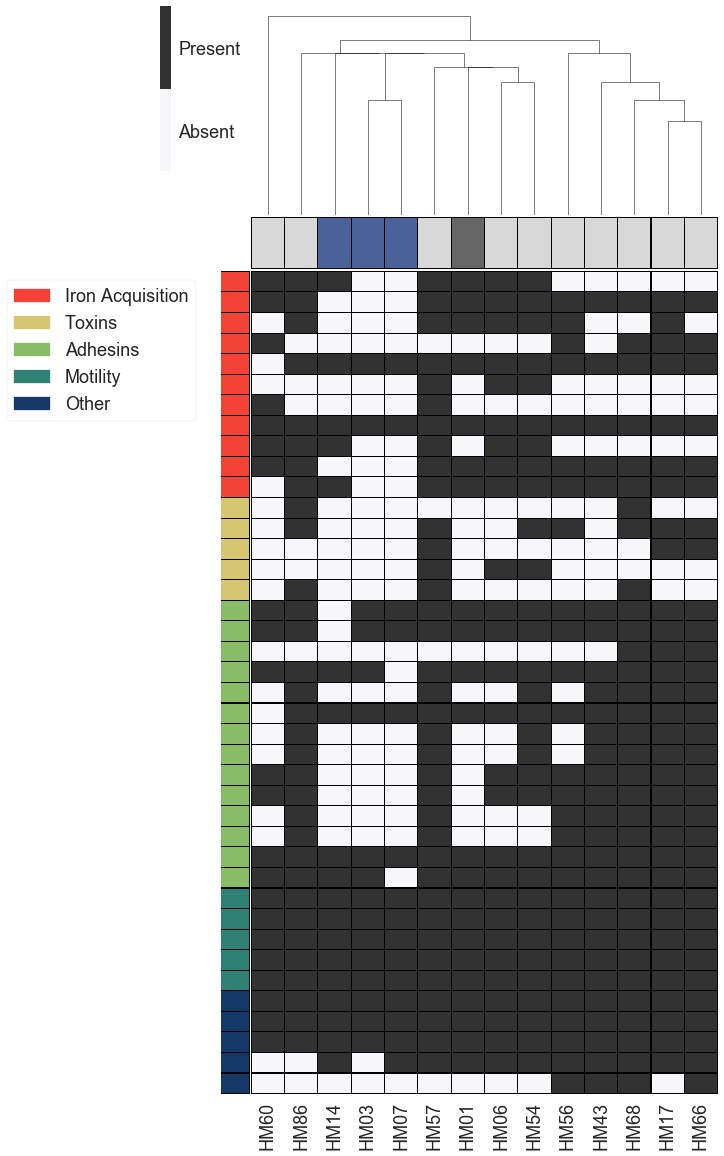

In [45]:
fig = plt.figure()
# Drawing the heatmap
g = sns.clustermap(pa_mat, row_cluster=False, col_linkage=strain_cluster, 
                   row_colors=row_colors, col_colors=col_colors, cmap=cmap,
                   linewidth = 0.05, linecolor="black",
                   figsize=(10,20));

# Adjusting the x and y labels
# Since this will be left panel of multipanel figures, do not want y labels
#la = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 14);
la = g.ax_heatmap.set_yticklabels("");

# Creating Legend
function_legend = [mpl.patches.Patch(color=c, label=l) for l,c in function_to_color.items()]
pg_legend = [mpl.patches.Patch(color=c, label=l) for l,c in phylogroup_to_color.items()]

# Displaying function legend
l2 = g.ax_heatmap.legend(handles=function_legend, bbox_to_anchor=(-0.1,1), frameon=True)

# Make a categorical colorbar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_ticks([ 0.25, 0.75])
colorbar.set_ticklabels([ 'Absent', 'Present'])
colorbar.solids.set_edgecolor("face")

# Save figure
filename = os.path.join(figures_dir, today+"_figure_1a.png")
g.savefig(filename, dpi=500, bbox_inches = "tight")

In [46]:
# Subsetting normalized expression values
cc_norm = norm_counts_invr[[c for c in norm_counts.columns if "_" in c]]
cc_norm.head()

,HM01_UR,HM01_UTI,HM03_UR,HM03_UTI,HM06_UR,HM06_UTI,HM07_UR,HM07_UTI,HM14_UR,HM14_UTI,...,HM57_UR,HM57_UTI,HM60_UR,HM60_UTI,HM66_UR,HM66_UTI,HM68_UR,HM68_UTI,HM86_UR,HM86_UTI
c3990,0.405352,0.343133,0.297610,0.273905,0.426598,0.399368,0.557211,0.470478,0.212749,0.365008,...,0.229112,0.501387,0.060298,0.247257,0.221300,0.582050,0.501373,0.475963,0.271934,0.507297
c3610,NaN,NaN,NaN,NaN,1.208298,0.719084,NaN,NaN,NaN,NaN,...,1.216112,0.469373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c0185,1.676927,1.121867,1.614377,1.044645,1.930701,1.853025,1.647179,1.622451,1.637839,0.993734,...,1.588938,1.681464,NaN,NaN,1.559636,1.671450,1.335236,1.106731,1.540000,1.464416
c3625,NaN,NaN,NaN,NaN,1.826897,1.157014,NaN,NaN,-1.791764,-1.925959,...,0.834638,-0.448106,2.895359,0.498714,NaN,NaN,NaN,NaN,-0.529122,-0.593276
c2883,NaN,NaN,NaN,NaN,-0.938896,-0.916711,NaN,NaN,NaN,NaN,...,-1.245912,-0.711824,-1.038165,-0.476863,-1.425701,-0.833505,-0.676137,-0.522897,-1.023915,-0.894468


In [47]:
# Visualization
# Adding gene names
counts = vg_info.merge(cc_norm, left_index=True, right_index=True).set_index("gene_name")

# Getting URINE counts
counts_ur = counts[[c for c in counts.columns if "UR" in c ]]
counts_ur.columns = [c.split("_")[0] for c in counts_ur.columns]
counts_ur.index.name=""
# Getting UTI counts
counts_uti = counts[ [c for c in counts.columns if "UTI" in c ]]
counts_uti.columns = [c.split("_")[0] for c in counts_uti.columns]
counts_uti.index.name=""
counts_ur.head()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86
,,,,,,,,,,,,,,
iutA (89.54%),0.188113,NaN,1.768825,NaN,-2.093799,NaN,NaN,1.611861,NaN,0.699216,2.492659,NaN,NaN,0.067573
chuA (99.51%),1.824854,NaN,2.098377,NaN,NaN,1.914329,1.132361,1.728668,1.873803,1.716513,2.005093,2.082153,0.134387,1.884218
hma (99.99%),2.173766,NaN,1.519182,NaN,NaN,-0.770228,NaN,1.438463,-0.689333,1.345281,NaN,NaN,NaN,-0.689462
iroN (99.38%),NaN,NaN,NaN,NaN,NaN,1.907990,NaN,NaN,2.146290,NaN,2.574295,2.429176,0.565465,NaN
fhuA (95.06%),1.676927,1.614377,1.930701,1.647179,1.637839,1.663088,1.465234,1.505024,1.625827,1.588938,NaN,1.559636,1.335236,1.540000


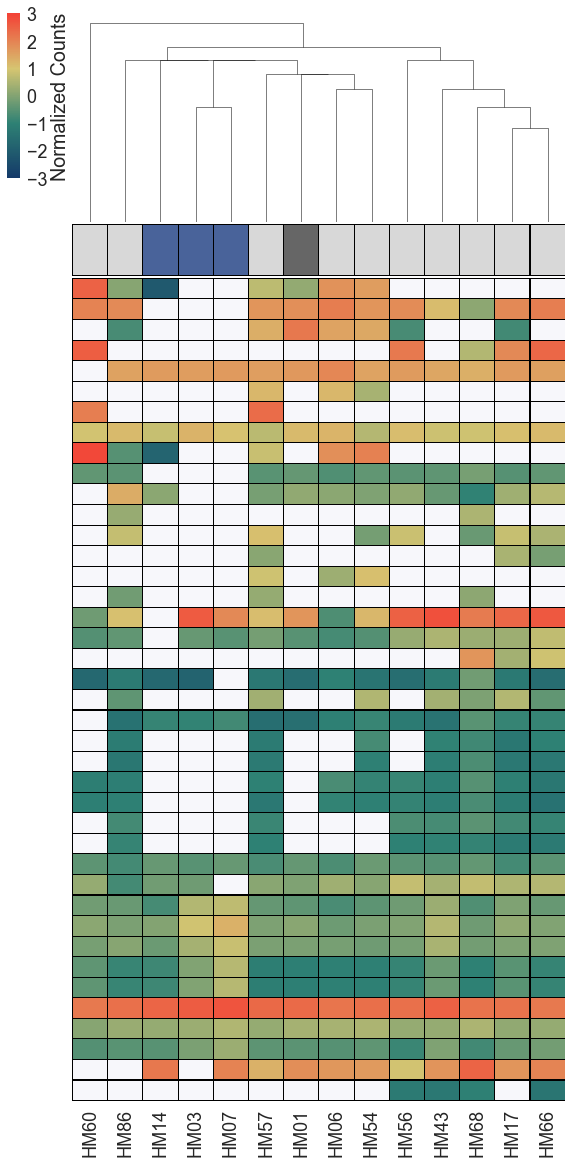

In [48]:
# URINE
cmap = my_cmap # From settings
cmap.set_bad(color='#f7f7fb')

#Drawind the heatmap
ur_h = sns.clustermap(counts_ur, row_cluster=False, col_linkage=strain_cluster, 
                      col_colors=col_colors,cmap = cmap, 
                      linewidth = 0.05, linecolor='black',
                      figsize = (10,20), vmin = -3, vmax = 3,
                      cbar_kws={"label":"Normalized Counts", });

# Adjusting the x and y labels
#la = ur_h.ax_heatmap.set_yticklabels(ur_h.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 14);
# Middle panel, don't want any labels
la = ur_h.ax_heatmap.set_yticklabels("");

# Saving file
filename2 = os.path.join(figures_dir, today+"_figure_1b.png")
ur_h.savefig(filename2, dpi=500, bbox_inches = "tight")

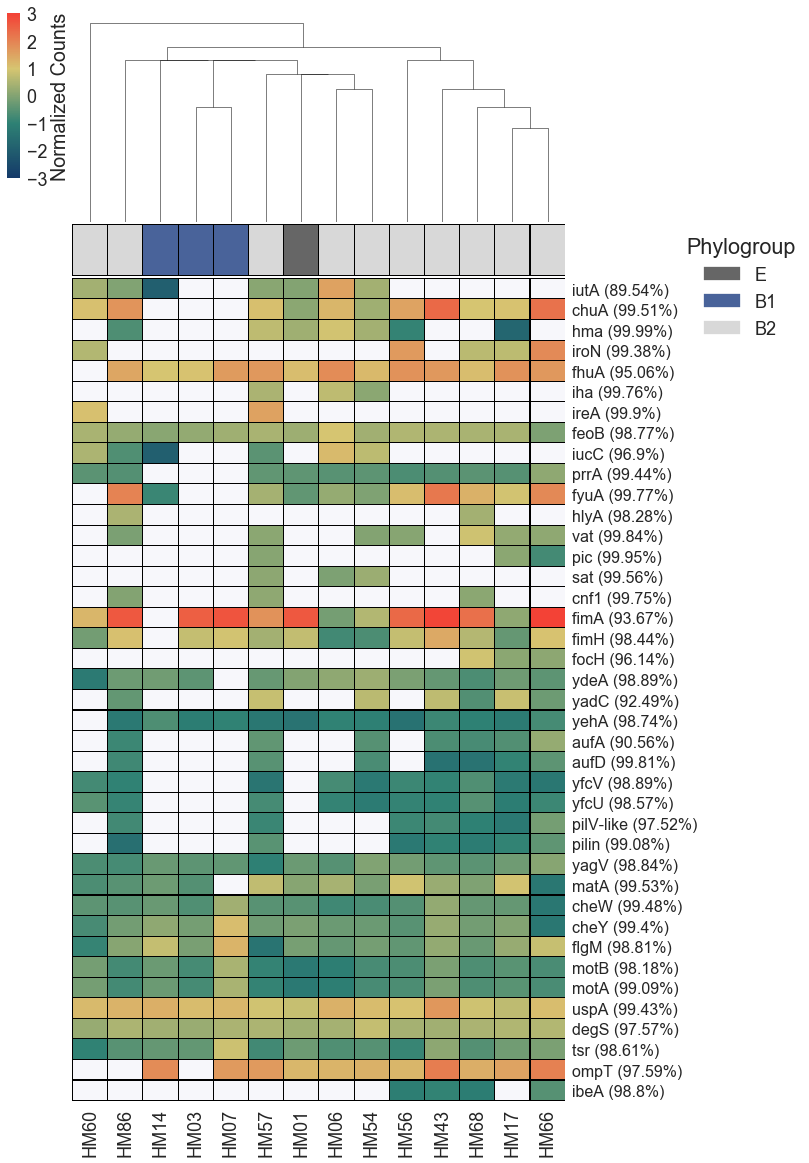

In [50]:
# PATIENTS
# Drawing the heatmap
col_colors.name = ''
uti_h = sns.clustermap(counts_uti, row_cluster=False, col_linkage=strain_cluster, 
                       col_colors=col_colors,cmap = cmap, 
                       linewidth = 0.05, linecolor = 'black',
                       figsize = (10,20), vmin = -3, vmax = 3, 
                       cbar_kws={"label":"Normalized Counts",});

# Adjusting the x and y labels
la = uti_h.ax_heatmap.set_yticklabels(uti_h.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 16);
l2 = uti_h.ax_heatmap.legend(handles=pg_legend, bbox_to_anchor=(1.5,1.07))
l2.set_title("Phylogroup")
filename3 = os.path.join(figures_dir, today+"_figure_1c.png")
uti_h.savefig(filename3, dpi=500, bbox_inches = "tight")